# get sample data 

In [2]:
import discogs_client
# authenticate to DISCOGS.COM
token = 'FBvXNlFYwMjpXpOkCBYtlyNdawVggJqXcQZJLoJC'
discogs = discogs_client.Client('myApp',  user_token= token)

In [5]:
# name, year, first release discogs id
albums = [
    ["From Her To Eternity", 1984, 399486],
    ["The Firstborn Is Dead", 1985, 407865],
    ["Your Funeral ... My Trial", 1986, 4705533],
    ["Kicking Against The Pricks", 1986, 431654],
    ["Tender Prey", 1988, 325250],
    ["The Good Son", 1990, 412390],
    ["Henry's Dream", 1992, 386584],
    ["Let Love In", 1994, 6539255],
    ["Murder Ballads", 1996, 370564],
    ["The Boatman's Call", 1997, 370607],
    ["No More Shall We Part", 2001, 424340],
    ["Nocturama", 2002, 380437],
    ["Abattoir Blues / The Lyre Of Orpheus", 2004, 379708],
    ["Dig, Lazarus, Dig!!!", 2008, 1268853],
    ["Push The Sky Away", 2012, 4262582],
    ["Skeleton Tree", 2016, 8989572],
    ["Ghosteen", 2019, 14179590],
]

In [6]:
import pandas as pd
import time

In [7]:
def get_tracklists(albums_list):
    # empty dataframe
    albums_info = pd.DataFrame()
    # empty list for each final column
    col_year, col_album, col_track_position, col_track_title = [], [], [], []
    # for every album
    for album in albums_list:
        # get the relase
        release = discogs.release(album[2])
        # get the release's master
        release_master = release.master
        # get master tracklist
        tracklist = release_master.tracklist
        # wait - too fast will disconnect the API
        time.sleep(2)
        # for each track populate the columns
        for track in tracklist:
            col_year.append(album[1])
            col_album.append(album[0])
            col_track_position.append(track.position)
            col_track_title.append(track.title)
    # populate the dataframe
    albums_info['year'] = col_year
    albums_info['album'] = col_album
    albums_info['track_position'] = col_track_position
    albums_info['track_title'] = col_track_title
    # return dataframe
    return albums_info


In [16]:
albums_info = get_tracklists(albums)

In [17]:
#cleand rows without track position - not tracks
albums_info = albums_info[albums_info.track_position != '']

In [20]:
albums_info.reset_index(inplace=True)

In [25]:
albums_info.drop(columns=['index'],inplace=True)


In [26]:
# overwrite track position with generated numbers instead of inconsistent source (i.e. vinyls are A1, A2, B1)
for i in range(albums_info.shape[0]-1):
    if i == 0 or albums_info.loc[i, 'album'] != albums_info.loc[i-1, 'album']:
        albums_info.loc[i, 'track_position'] = 1
    else:
        albums_info.loc[i, 'track_position'] = int(albums_info.loc[i-1, 'track_position']) + 1

# look at sample

In [163]:
albums_info.head(20)

,year,album,track_position,track_title,period
0,1984,From Her To Eternity,1,Avalanche,1984-1984
1,1984,From Her To Eternity,2,Cabin Fever!,1984-1984
2,1984,From Her To Eternity,3,Well Of Misery,1984-1984
3,1984,From Her To Eternity,4,From Her To Eternity,1984-1984
4,1984,From Her To Eternity,5,Saint Huck,1984-1984
5,1984,From Her To Eternity,6,Wings Off Flies,1984-1984
6,1984,From Her To Eternity,7,A Box For Black Paul,1984-1984
7,1985,The Firstborn Is Dead,1,Tupelo,1985-1985
8,1985,The Firstborn Is Dead,2,Say Goodbye To The Little Girl Tree,1985-1985
9,1985,The Firstborn Is Dead,3,Train Long-Suffering,1985-1985


In [57]:
def add_period_bins(discog, bin_size):
    '''adds a column with period bins of given size starting 0th year of decade of the first release'''
    bins = []
    start_year = int(str(discog.year.min())[:3]+'0')
    last_year = int(str(discog.year.max())[:2]+str(int(str(discog.year.max())[2])+1)+'0')
    year = start_year
    while year < last_year:
        bin = str(year) + '-' + str(year + bin_size-1)
        discog.loc[(discog['year'] >= year) & (discog['year'] < year + bin_size), 'period'] = bin
        year += bin_size

In [63]:
def albums_per_period(discog, bin_size):
    '''returns a table with a count of unique albums per period'''
    add_period_bins(discog, bin_size)
    return pd.pivot_table(
        albums_info,
        index = 'period',
        values = 'album',
        aggfunc = lambda x: len(x.unique())
    )

In [73]:
def songs_per_period(discog, bin_size):
    '''returns a table with a count of unique songs per period'''
    add_period_bins(discog, bin_size)
    return pd.pivot_table(
        albums_info,
        index = 'period',
        values = 'track_title',
        aggfunc = lambda x: len(x.unique())
    )

In [114]:
def albums_songs_per_period(discog, bin_size):
    '''returns a table with a count of unique songs per period'''
    add_period_bins(discog, bin_size)
    return pd.pivot_table(
        albums_info,
        index = 'period',
        values = ['album', 'track_title'],
        aggfunc = lambda x: len(x.unique())
    )

In [158]:
import matplotlib.pyplot as plt
%matplotlib inline


def plot_albums_songs_per_period(discog, bin_size):
    '''returns two plots - number of albums per period and number of songs per period'''
    
    data = albums_songs_per_period(discog,bin_size)
    
    fig, ax1 = plt.subplots(figsize=(11,7))

    color = 'tab:red'
    ax1.set_xlabel('period')
    ax1.set_ylabel('number of albums', color=color)
    ax1.plot(data.index.tolist(), data.album, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.tick_params(axis='x', labelrotation=45)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('number of songs', color=color)  # we already handled the x-label with ax1
    ax2.plot(data.index.tolist(), data.track_title, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label may be slightly clipped

    plt.show()

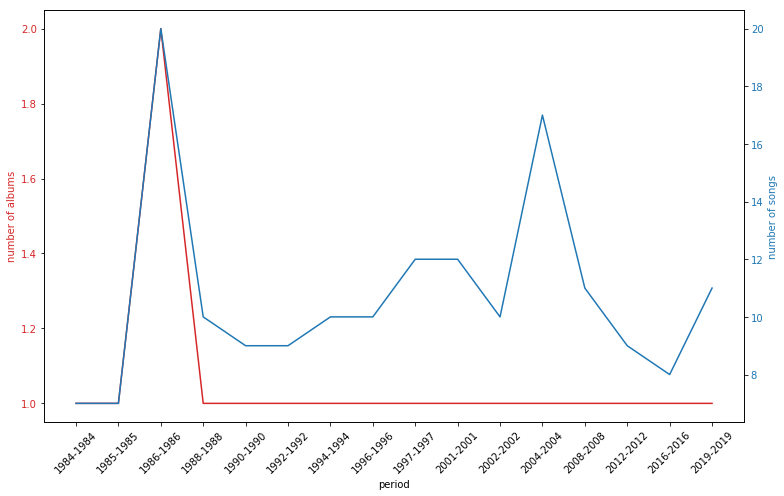

In [161]:
plot_albums_songs_per_period(albums_info,1)